In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

## Dataset statistics

In [5]:
network_df = pd.read_table('network_with_weights.edgelist', header=None)
network_df.columns=["source","target","weight"]
network_df

,source,target,weight
0,MAL944N3R,2P070I351,0.981574
1,LPAXLZS35,2IUMVXWR8,0.977001
2,IYMKO9LF4,017MQ4ZTB,0.975498
3,6CJFVPO4U,P86LCJZFV,0.974873
4,LBTT9SRNJ,DYH3UPRT6,0.970838
...,...,...,...
1324319,86UWY1A4I,ETGHECTWF,0.517547
1324320,G924N98WP,7C1CNT3N8,0.517547
1324321,GJFNQHU5H,WCNQGLB0N,0.517547
1324322,I2PJ9B2YL,MK01ZI3EW,0.517547


In [6]:
G = nx.from_pandas_edgelist(network_df, edge_attr=True)
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

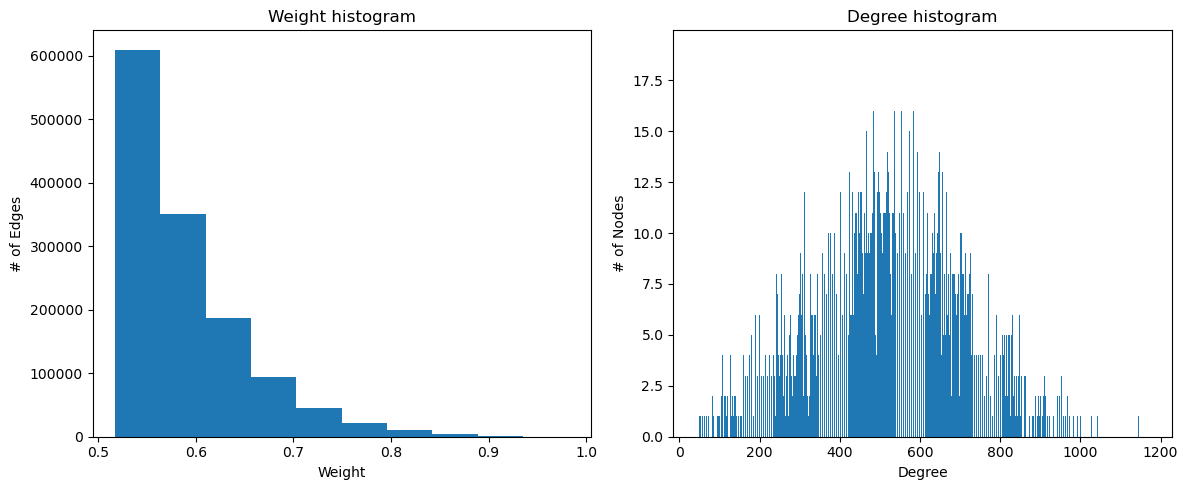

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.hist(network_df['weight'])
ax1.set_title("Weight histogram")
ax1.set_xlabel("Weight")
ax1.set_ylabel("# of Edges")

ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()
# fig.savefig('dist.png', dpi=300)

## Louvain community detection

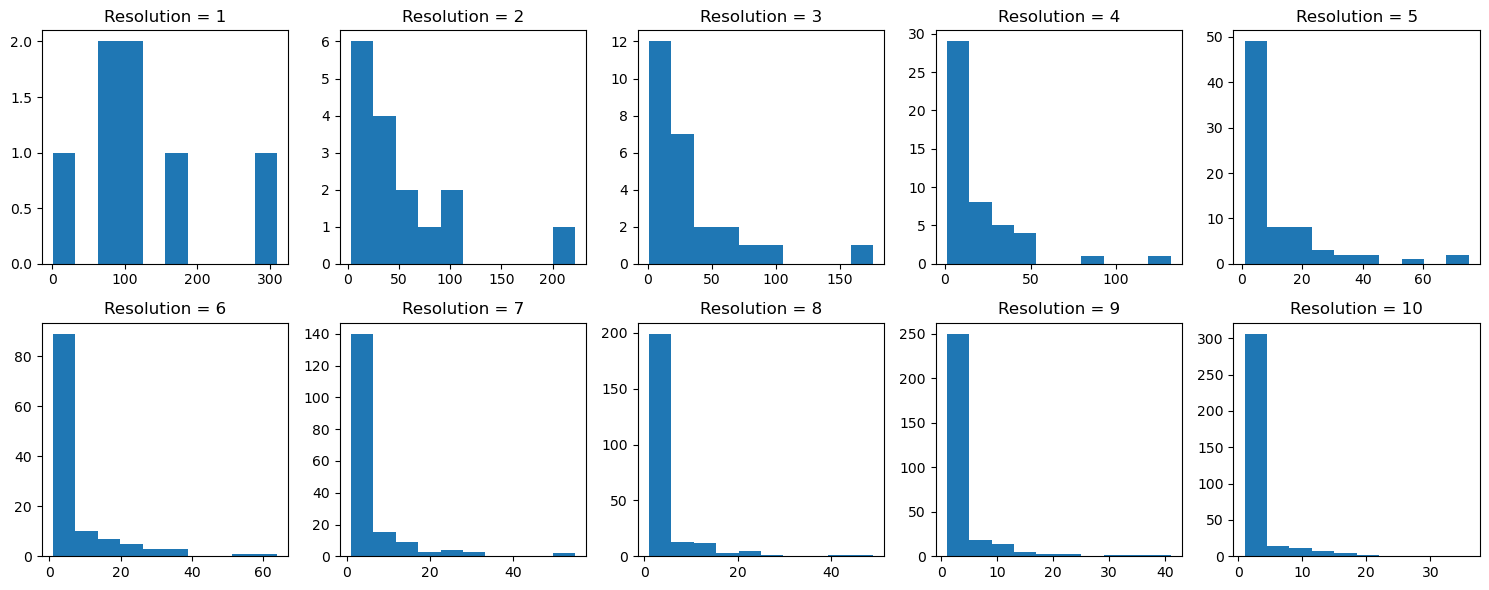

In [8]:
# Load proteins of interest from CSV
proteins_df = pd.read_csv("onecluster.csv")
proteins_of_interest = set(proteins_df['xxx'].values)

# Create figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Run Louvain with different resolutions
for i, resolution in enumerate(range(1,11)):
    # Detect communities
    c = nx.community.louvain_communities(G, resolution=resolution, seed=42)
    
    # Filter to proteins of interest
    filtered_c = [protein_set.intersection(proteins_of_interest) for protein_set in c]
    filtered_c = [comm for comm in filtered_c if len(comm) > 0]
    
    # Get community sizes
    community_sizes = [len(community) for community in filtered_c]
    
    # Plot histogram
    axes[i].hist(community_sizes, bins=10)
    axes[i].set_title(f'Resolution = {resolution}')

plt.tight_layout()
# plt.savefig('resolution_comparison.png', dpi=300)
plt.show()

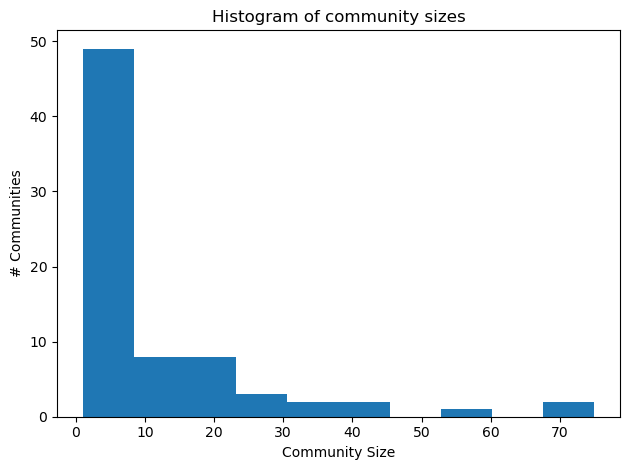

In [9]:
# settle at resolution 5
fig, ax = plt.subplots()
# Detect communities
c = nx.community.louvain_communities(G, resolution=5, seed=42)

# Filter to proteins of interest
filtered_c = [protein_set.intersection(proteins_of_interest) for protein_set in c]
filtered_c = [comm for comm in filtered_c if len(comm) > 0]

# Get community sizes
community_sizes = [len(community) for community in filtered_c]

# Plot histogram
ax.hist(community_sizes, bins=10)
ax.set_xlabel('Community Size')
ax.set_ylabel('# Communities')
ax.set_title('Histogram of community sizes')

plt.tight_layout()
# plt.savefig('res_5_comm_sizes.png', dpi=300)

## Random Initialization

In [10]:
# Filter to keep only interactions where both proteins are in the set
filtered_df = network_df[
    (network_df['source'].isin(proteins_of_interest)) & 
    (network_df['target'].isin(proteins_of_interest))
]

In [11]:
G_fil = nx.from_pandas_edgelist(filtered_df, edge_attr=True)

Running Louvain algorithm 1000 times with different random seeds...
Completed 100 iterations. Current best modularity: 0.223290
Completed 200 iterations. Current best modularity: 0.223290
Completed 300 iterations. Current best modularity: 0.225921
Completed 400 iterations. Current best modularity: 0.225921
Completed 500 iterations. Current best modularity: 0.225921
Completed 600 iterations. Current best modularity: 0.225921
Completed 700 iterations. Current best modularity: 0.225921
Completed 800 iterations. Current best modularity: 0.225921
Completed 900 iterations. Current best modularity: 0.226041
All 1000 iterations completed. Best modularity found: 0.226605 (with seed 4014745)


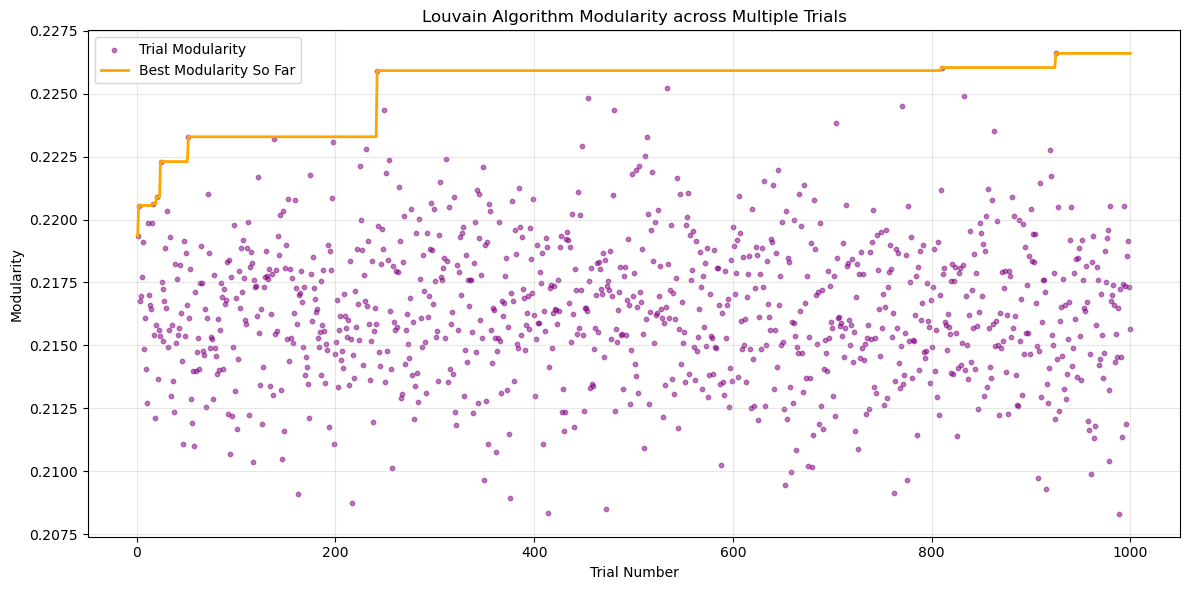

Best modularity: 0.226605
Best seed: 4014745
Number of communities found: 106
Community sizes: [1, 1, 1, 44, 1, 1, 18, 1, 26, 1, 25, 1, 1, 59, 1, 1, 1, 1, 22, 1, 2, 13, 3, 1, 1, 18, 5, 19, 14, 4, 18, 7, 6, 24, 1, 2, 8, 1, 1, 27, 1, 1, 1, 1, 11, 1, 1, 1, 1, 1, 12, 1, 11, 1, 1, 1, 1, 1, 1, 8, 4, 2, 1, 27, 1, 1, 1, 33, 1, 1, 1, 36, 53, 1, 1, 40, 1, 10, 1, 2, 73, 1, 1, 18, 6, 1, 13, 1, 15, 2, 1, 1, 17, 1, 1, 4, 1, 8, 1, 1, 2, 1, 1, 1, 9, 1]


In [15]:
# Set the number of iterations
num_iterations = 1000

# Variables to track the best partition
best_partition = None
best_modularity = -1  # Modularity ranges from -1 to 1, so -1 is a safe starting point
best_seed = None

# Lists to store modularity values for plotting
all_modularities = []
best_so_far = []

# Run Louvain algorithm multiple times with different random seeds
print(f"Running Louvain algorithm {num_iterations} times with different random seeds...")

random.seed(42)
for i in range(num_iterations):
    # Print progress update every 100 iterations
    if i % 100 == 0 and i > 0:
        print(f"Completed {i} iterations. Current best modularity: {best_modularity:.6f}")
    
    # Generate a random seed
    seed = random.randint(0, 10000000)
    
    # Run Louvain with this random seed using NetworkX
    partition = nx.community.louvain_communities(G_fil, seed=seed, weight='weight', resolution=5)
    
    # Calculate modularity using NetworkX
    modularity = nx.community.modularity(G_fil, partition, weight='weight')
    
    # Store the modularity value
    all_modularities.append(modularity)
    
    # Update best partition if this one has higher modularity
    if modularity > best_modularity:
        best_modularity = modularity
        best_partition = partition
        best_seed = seed
    
    # Store the best modularity so far
    best_so_far.append(best_modularity)

print(f"All {num_iterations} iterations completed. Best modularity found: {best_modularity:.6f} (with seed {best_seed})")

# Create plot
plt.figure(figsize=(12, 6))

# Plot individual trial modularities
plt.scatter(range(1, num_iterations + 1), all_modularities, s=10, alpha=0.5, c='purple', label='Trial Modularity')

# Plot best modularity so far
plt.plot(range(1, num_iterations + 1), best_so_far, linewidth=2, color='orange', label='Best Modularity So Far')

# Add labels and title
plt.xlabel('Trial Number')
plt.ylabel('Modularity')
plt.title('Louvain Algorithm Modularity across Multiple Trials')
plt.legend()
plt.grid(True, alpha=0.3)

# Improve visual appearance
plt.tight_layout()

# Save the plot if desired
plt.savefig('louvain_modularity_trials.png', dpi=300)

# Show the plot
plt.show()

# Print summary statistics
print(f"Best modularity: {best_modularity:.6f}")
print(f"Best seed: {best_seed}")
print(f"Number of communities found: {len(best_partition)}")
print(f"Community sizes: {[len(community) for community in best_partition]}")